# Parcel rollup

This notebook demonstrates how to pull data from the AI features API on a per parcel basis, filter out features we do not not consider part of the parcels, and to transform (rollup) the data into a tabular format.

In [1]:
# Use Black to enforce style in the notebook, use `pip install nb_black` to install.
# https://pypi.org/project/nb-black/
%load_ext nb_black
# Reload packages to always use latest
%matplotlib inline
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import concurrent.futures
import json
import os
from pathlib import Path
import shutil
import time

from descartes import PolygonPatch
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon, shape
import shapely.wkt
from tqdm.notebook import tqdm

# Local utilities
import utils

# Projections CRS strings
SOURCE_CRS = "EPSG:4326"
ALBERS_CRS = "esri:102003"

<IPython.core.display.Javascript object>

## API params

In [3]:
# Store your Nearmap API Key in an environment variable so it doesn't appear in the notebook.
API_KEY = os.environ["API_KEY"]

# Data date range
SINCE, UNTIL = ("2016-01-01", "2022-12-31")

# Get pack codes from https://api.nearmap.com/ai/features/v4/packs.json
PACKS = ",".join(
    [
        "building",
        "building_char",
        "solar",
        "construction",
        "trampoline",
        "pool",
        "roof_char",
    ]
)

# Number of concurrent workers
THREADS = 10
CHUNK_SIZE = 100
PROCESSES = 8

# Use https://api.nearmap.com/ai/features/v4/classes.json to get class IDs
BUILDING_ID = "a2e4ae39-8a61-5515-9d18-8900aa6e6072"
ROOF_ID = "c08255a4-ba9f-562b-932c-ff76f2faeeeb"
TRAMPOLINE_ID = "753621ee-0b9f-515e-9bcf-ea40b96612ab"
POOL_ID = "0339726f-081e-5a6e-b9a9-42d95c1b5c8a"
CONSTRUCTION_ID = "a2a81381-13c6-57dc-a967-af696e45f6c7"
SOLAR_ID = "3680e1b8-8ae1-5a15-8ec7-820078ef3298"

<IPython.core.display.Javascript object>

## File system params

In [4]:
PARCELS_PATH = Path("../data/parcels/parcel_sample_chicago.csv")
RESPONSE_DIR = Path("../data/response_cache")
OUTPUT_PATH = Path("../data/processed/parcel_sample_chicago.csv")

<IPython.core.display.Javascript object>

## Feature filtering params

In [5]:
# Min sizes are in squared meters
MIN_SIZES = {
    BUILDING_ID: 16,
    TRAMPOLINE_ID: 9,
    POOL_ID: 9,
    CONSTRUCTION_ID: 9,
    SOLAR_ID: 9,
}
MIN_SIZES[ROOF_ID] = MIN_SIZES[BUILDING_ID]

# Min confidence values
MIN_CONFIDENCES = {
    BUILDING_ID: 0.8,
    TRAMPOLINE_ID: 0.7,
    POOL_ID: 0.7,
    CONSTRUCTION_ID: 0.8,
    SOLAR_ID: 0.7,
}
MIN_CONFIDENCES[ROOF_ID] = MIN_CONFIDENCES[BUILDING_ID]

# Min area and ratio in parcel.
# Logic is set up to keep a feature if either one of the area and ratio limits are met.
MIN_AREA_IN_PARCEL = {
    BUILDING_ID: 16,
    TRAMPOLINE_ID: 5,
    POOL_ID: 5,
    CONSTRUCTION_ID: 5,
    SOLAR_ID: 5,
}
MIN_AREA_IN_PARCEL[ROOF_ID] = MIN_AREA_IN_PARCEL[BUILDING_ID]
MIN_RATIO_IN_PARCEL = {
    BUILDING_ID: 0.5,
    TRAMPOLINE_ID: 0.5,
    POOL_ID: 0.5,
    CONSTRUCTION_ID: 0.5,
    SOLAR_ID: 0.5,
}
MIN_RATIO_IN_PARCEL[ROOF_ID] = MIN_RATIO_IN_PARCEL[BUILDING_ID]

<IPython.core.display.Javascript object>

In [6]:
# Cleanup
# WARNING: this clears the cache
shutil.rmtree(RESPONSE_DIR, ignore_errors=True)
RESPONSE_DIR.mkdir()
# Create output directory if it doesn't exist
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

# Load parcel data

We need our parcel data to have two things:
 - A unique identifier
 - A geometry (in this case in EPSG 4326)

Number of parcels 2180


,id,properties,geometry,geometry_epsg4326
0,8ced57c8-b42e-57d4-84af-41c7094818fc,"{'state': 'IL', 'county': 'COOK', 'taxapn': '1...","MULTIPOLYGON (((673121.908 503404.629, 673117....","MULTIPOLYGON (((-87.83864 41.73505, -87.83865 ..."
1,fc5d7cdf-d57c-59c6-ba84-60c1763be619,"{'state': 'IL', 'county': 'COOK', 'taxapn': '1...","MULTIPOLYGON (((673162.929 503515.254, 673160....","MULTIPOLYGON (((-87.83803 41.73600, -87.83804 ..."
2,239965dc-fd74-506a-998a-38caddeb1e30,"{'state': 'IL', 'county': 'COOK', 'taxapn': '1...","MULTIPOLYGON (((673064.248 503499.649, 673059....","MULTIPOLYGON (((-87.83924 41.73594, -87.83925 ..."
3,844f2c45-fc7b-509c-bffd-a30e6b6e00fd,"{'state': 'IL', 'county': 'COOK', 'taxapn': '2...","MULTIPOLYGON (((673347.338 503118.105, 673342....","MULTIPOLYGON (((-87.83622 41.73232, -87.83623 ..."
4,cf3d685e-6139-5dda-bf7c-318df0f9888c,"{'state': 'IL', 'county': 'COOK', 'taxapn': '2...","MULTIPOLYGON (((673267.939 503100.113, 673228....","MULTIPOLYGON (((-87.83720 41.73222, -87.83766 ..."


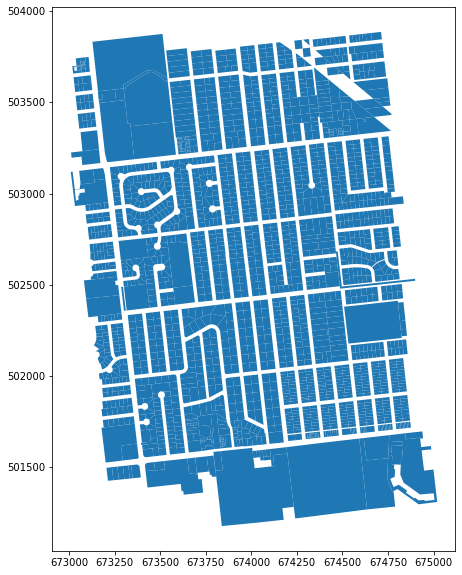

<IPython.core.display.Javascript object>

In [7]:
# Read parcel data set and convert to geopandas dataframe
parcels_df = pd.read_csv(PARCELS_PATH)
parcels_gdf = gpd.GeoDataFrame(
    parcels_df.drop("geometry", axis=1),
    geometry=parcels_df.geometry.apply(shapely.wkt.loads),
    crs=SOURCE_CRS,
)
del parcels_df
# Check that identifier is unique
assert not parcels_gdf.id.duplicated().any()

# Project parcels to Albers equal area (keep EPSG 326 around, we'll need both)
parcels_gdf["geometry_epsg4326"] = parcels_gdf["geometry"]
parcels_gdf = parcels_gdf.to_crs(ALBERS_CRS)

# Show example and plot
print(f"Number of parcels {len(parcels_gdf)}")
parcels_gdf.plot(figsize=(10, 10))
display(parcels_gdf.head())

# Fetching data from the API

By using a local cache we do not have to make the same request multiple times.

In [8]:
def cached_get_payload(parcel_id, geometry, force=False):
    """
    Get API payload, either from API or from cache
    """
    cache_path = RESPONSE_DIR / f"{parcel_id}.json"
    if cache_path.exists() and not force:
        with open(cache_path, "r") as f:
            payload = json.load(f)
    else:
        payload, error = utils.get_features(
            geometry, PACKS, API_KEY, since=SINCE, until=UNTIL
        )
        if error:
            return None, error

        with open(cache_path, "w") as f:
            json.dump(payload, f, indent=2)
    return payload, None

<IPython.core.display.Javascript object>

In [9]:
# Example usage of cached_get_payload
index = 0
start = time.time()
payload, error = cached_get_payload(
    parcels_gdf.id.iloc[index], parcels_gdf.geometry_epsg4326.iloc[index]
)
print(f"Loaded {len(payload['features'])} features in {time.time() - start} seconds")

start = time.monotonic()
payload, error = cached_get_payload(
    parcels_gdf.id.iloc[index], parcels_gdf.geometry_epsg4326.iloc[index]
)
print(
    f"Loaded {len(payload['features'])} features in {time.monotonic() - start} seconds"
)

# We sometimes get explainable errors that we have to deal with.
# In this example the AOI is massive, causing the API to fail.
payload, error = cached_get_payload(
    "size example", parcels_gdf.geometry_epsg4326.iloc[index].buffer(10)
)
print(f"Error for large parcel: {error}")

Loaded 5 features in 0.4637937545776367 seconds
Loaded 5 features in 0.005880199954845011 seconds
Error for large parcel: ApiError.AOI_EXCEEDS_MAX_SIZE


<IPython.core.display.Javascript object>

# Create geodataframe

We use geopandas for efficient geo-processing. The examples show features for a few parcels. Note how features on the edge of parcel boundaries are included.

In [10]:
def create_geodataframe(payload, geometry):
    """
    Convert a payload returned by the features API into a geodataframe.

    Note: Geometries are projected to Albers equal area. Area calculations are therefore in metres squared.
    """
    # Cast geojson to shapely
    for feature in payload["features"]:
        feature["geometry"] = shape(feature["geometry"])

    # Create geodataframe and project to Albers equal area for area based calculations
    if len(payload["features"]) > 0:
        features_gdf = gpd.GeoDataFrame(payload["features"], geometry="geometry")
    else:
        features_gdf = gpd.GeoDataFrame(
            [], columns=["classId", "areaSqm", "areaSqft", "confidence", "geometry"]
        )
    features_gdf = features_gdf.set_crs(SOURCE_CRS)
    features_gdf = features_gdf.to_crs(ALBERS_CRS)

    # Calculate the area of each feature that falls within the parcel
    features_gdf["intersectionArea"] = features_gdf.geometry.intersection(geometry).area
    # Calculate the ratio of a feature that falls within the parcel
    features_gdf["intersectionRatio"] = (
        features_gdf.intersectionArea / features_gdf.area
    )

    return features_gdf

<IPython.core.display.Javascript object>

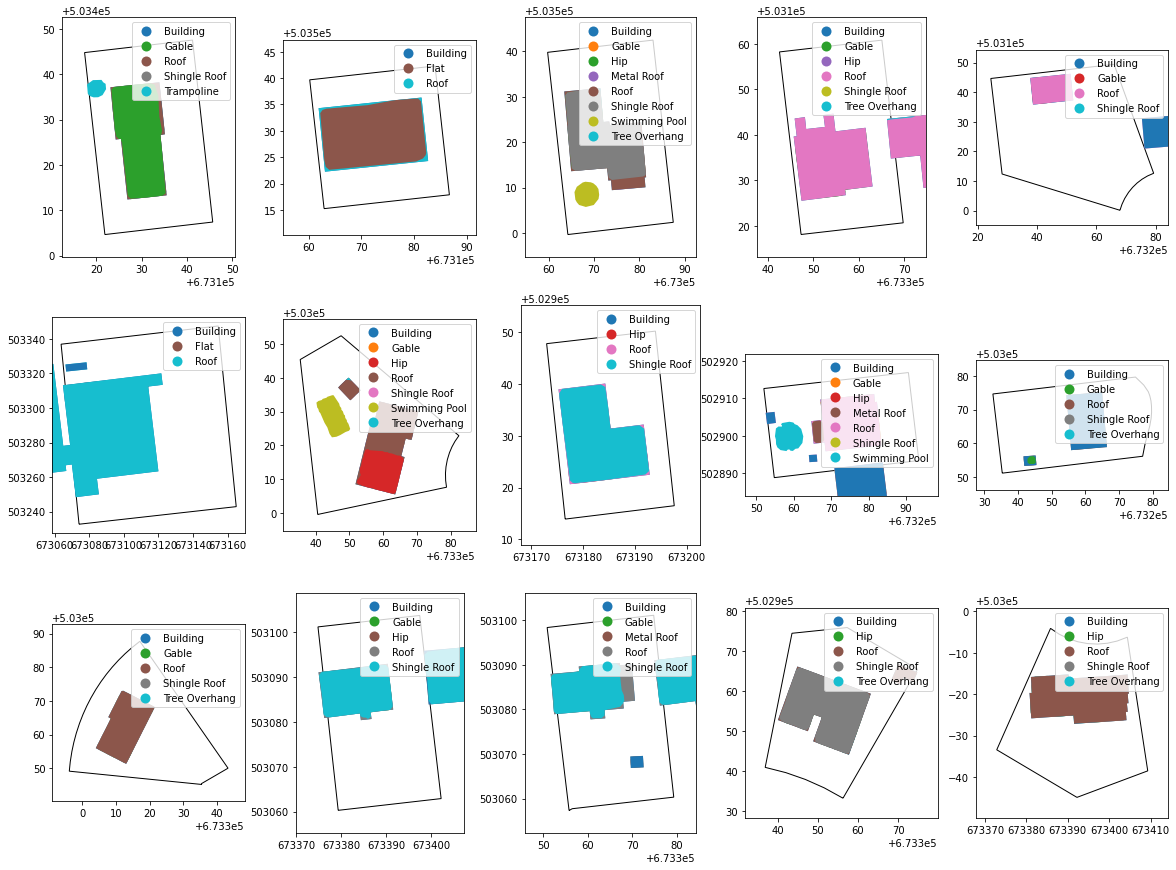

<IPython.core.display.Javascript object>

In [11]:
# Plot a few examples
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
axes = [ax for row in axes for ax in row]
for i, row in parcels_gdf.head(15).iterrows():
    payload, error = cached_get_payload(row.id, row.geometry_epsg4326)
    features_gdf = create_geodataframe(payload, row.geometry)
    features_gdf.plot(ax=axes[i], column="description", legend=True)
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - 5, row.geometry.bounds[2] + 5)
    axes[i].set_ylim(row.geometry.bounds[1] - 5, row.geometry.bounds[3] + 5)

# Filter features

As seen in the previous examples, there are often features on the edge of parcels that we want to reject. In this notebook we apply four filters:
 - Low area features
 - Low confidence features
 - Features that are mostly outside the parcel, unless there is significant area overlap
 - Feature classes without defined filtering parameters. In this case it will be classes like roof types and materials. We still have the attribute values with the roof features, so geometries are not needed.

In [12]:
def filter_features(features_gdf):
    """
    Filter features based on the defined filtering parameters
    """
    # Filter small features
    features_gdf = features_gdf[features_gdf.classId.map(MIN_SIZES) < features_gdf.area]
    # Filter low confidence features
    features_gdf = features_gdf[
        features_gdf.classId.map(MIN_CONFIDENCES) < features_gdf.confidence
    ]
    # Filter based on area and ratio in parcel
    area_mask = (
        features_gdf.classId.map(MIN_AREA_IN_PARCEL) < features_gdf.intersectionArea
    )
    ratio_mask = (
        features_gdf.classId.map(MIN_RATIO_IN_PARCEL) < features_gdf.intersectionRatio
    )
    features_gdf = features_gdf[area_mask | ratio_mask]

    return features_gdf


<IPython.core.display.Javascript object>

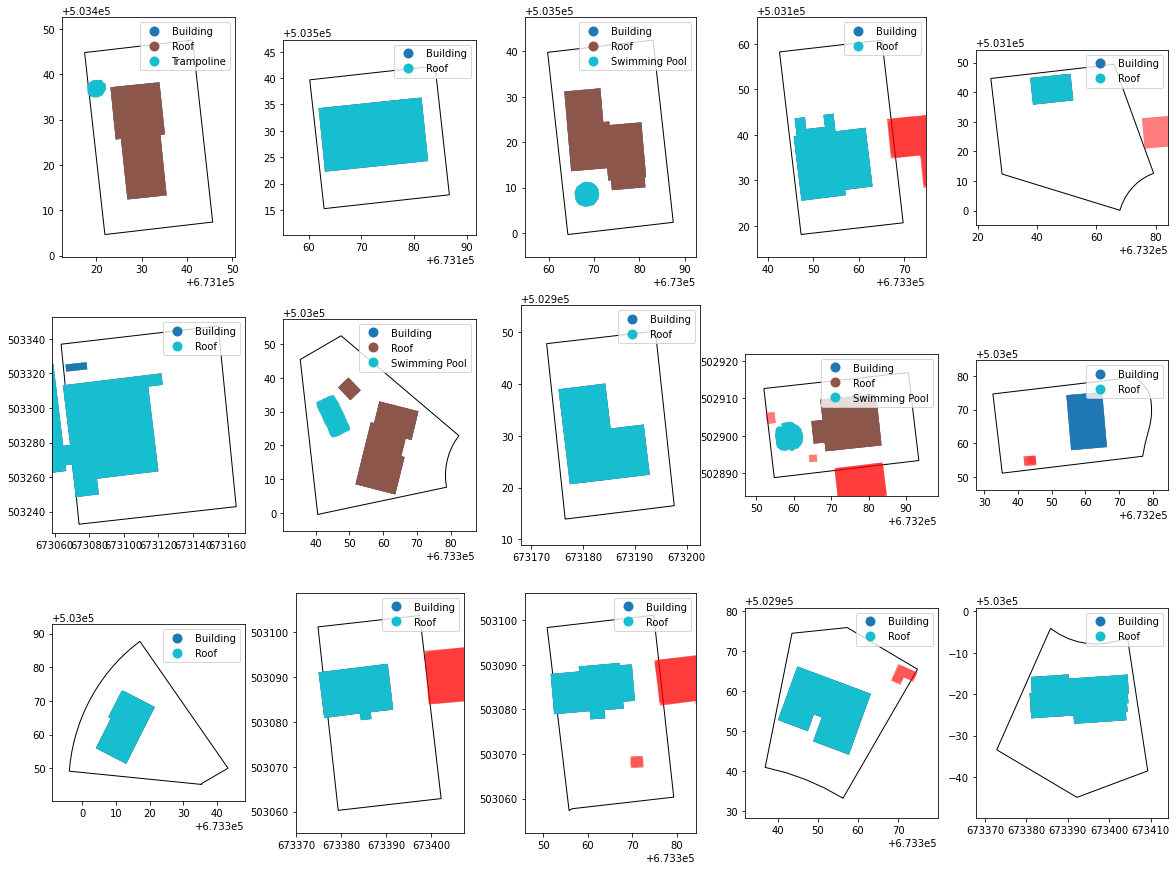

<IPython.core.display.Javascript object>

In [13]:
# Plot a few examples
# Red features were discarded
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
axes = [ax for row in axes for ax in row]
for i, row in parcels_gdf.head(15).iterrows():
    # Get API payload
    payload, error = cached_get_payload(row.id, row.geometry_epsg4326)
    # Create geo-df
    features_gdf = create_geodataframe(payload, row.geometry)
    # Plot all features
    features_gdf.plot(ax=axes[i], fc="red", alpha=0.3)
    # Filter features
    features_gdf = filter_features(features_gdf)
    # Plot remaining features
    features_gdf.plot(ax=axes[i], column="description", legend=True)
    # Show parcel boundary
    axes[i].add_patch(
        PolygonPatch(row.geometry, fc="none", ec="k", alpha=1, zorder=0, lw=1)
    )
    axes[i].set_xlim(row.geometry.bounds[0] - 5, row.geometry.bounds[2] + 5)
    axes[i].set_ylim(row.geometry.bounds[1] - 5, row.geometry.bounds[3] + 5)

# Create parcel rollup

Once we have the features in a parcel, all that remains is to flatten the features and attributes to tabular foramt. Note that roof and building values relate to the dominant building and roof within a parcel. The dmoninant building is defined as the building with the largest area within the parcel.

In [14]:
def flatten_building_attributes(attributes):
    """
    Flatten building attributes
    """
    flattened = {}
    for attribute in attributes:
        if "has3dAttributes" in attribute:
            flattened["building_has_3d_attributes"] = (
                "Y" if attribute["has3dAttributes"] else "N"
            )
            if attribute["has3dAttributes"]:
                flattened["building_height"] = attribute["height"]
                for k, v in attribute["numStories"].items():
                    flattened[f"building_num_storeys_{k}_confidence"] = v
    return flattened


def flatten_roof_attributes(attributes):
    """
    Flatten roof attributes
    """
    flattened = {}
    for attribute in attributes:
        if "components" in attribute:
            for component in attribute["components"]:
                name = component["description"].lower().replace(" ", "_")
                flattened[f"{name}_present"] = "Y" if component["areaSqm"] > 0 else "N"
                flattened[f"{name}_area"] = component["areaSqm"]
                flattened[f"{name}_confidence"] = component["confidence"]
                if "dominant" in component:
                    flattened[f"{name}_dominant"] = (
                        "Y" if component["dominant"] else "N"
                    )
        elif "has3dAttributes" in attribute:
            flattened["roof_has_3d_attributes"] = (
                "Y" if attribute["has3dAttributes"] else "N"
            )
            if attribute["has3dAttributes"]:
                flattened["roof_pitch"] = attribute["pitch"]
    return flattened


def building_and_roof_attributes(features_gdf):
    """
    Create flat (not nested) dictionary with building and roof attributes
    """
    parcel = {}
    roof_gdf = features_gdf[features_gdf.classId == ROOF_ID]
    if len(roof_gdf) > 0:
        dominant_roof_index = roof_gdf.intersectionArea.idxmax()
        dominant_roof = roof_gdf.loc[dominant_roof_index]
        dominant_building = features_gdf[
            features_gdf.id == dominant_roof.parentId
        ].iloc[0]
        parcel["building_present"] = "Y"
        parcel["roof_present"] = "Y"
        parcel["building_area_sqm"] = dominant_building.areaSqm
        parcel["building_area_sqft"] = dominant_building.areaSqft
        parcel["roof_area_sqm"] = dominant_roof.areaSqm
        parcel["roof_area_sqft"] = dominant_roof.areaSqft
        parcel["building_confidence"] = dominant_building.confidence
        parcel["roof_confidence"] = dominant_roof.confidence
        parcel.update(flatten_roof_attributes(dominant_roof.attributes))
        parcel.update(flatten_building_attributes(dominant_building.attributes))
        secondary_roofs = roof_gdf[roof_gdf.index != dominant_roof_index]
        parcel["secondary_roof_count"] = len(secondary_roofs)
        parcel["secondary_roof_area_sqm"] = secondary_roofs.areaSqm.sum()
        parcel["secondary_roof_area_sqft"] = secondary_roofs.areaSqft.sum()
    else:
        parcel["building_present"] = "N"
        parcel["roof_present"] = "N"
        parcel["building_area_sqm"] = 0
        parcel["roof_area_sqm"] = 0
        parcel["building_area_sqft"] = 0
        parcel["roof_area_sqft"] = 0
        parcel["building_confidence"] = 1
        parcel["roof_confidence"] = 1
        parcel["secondary_roof_count"] = 0
        parcel["secondary_roof_area_sqm"] = 0
        parcel["secondary_roof_area_sqft"] = 0
    return parcel


def feature_attributes(features_gdf):
    # Add present, area, and confidence for other classes
    parcel = {}
    for (name, class_id) in [
        ("construction", CONSTRUCTION_ID),
        ("trampoline", TRAMPOLINE_ID),
        ("pool", POOL_ID),
        ("solar", SOLAR_ID),
    ]:
        class_gdf = features_gdf[features_gdf.classId == class_id]
        parcel[f"{name}_present"] = "Y" if len(class_gdf) > 0 else "N"
        parcel[f"{name}_area_sqm"] = class_gdf.areaSqm.sum()
        parcel[f"{name}_area_sqft"] = class_gdf.areaSqft.sum()
        if parcel[f"{name}_present"] == "Y":
            parcel[f"{name}_confidence"] = 1 - (1 - class_gdf.confidence).prod()
        else:
            parcel[f"{name}_confidence"] = 1.0
    return parcel

<IPython.core.display.Javascript object>

In [15]:
# Example of flat dictionary for roof and building attributes
index = 0
payload, error = cached_get_payload(
    parcels_gdf.id.iloc[index], parcels_gdf.geometry_epsg4326.iloc[index]
)
features_gdf = create_geodataframe(payload, parcels_gdf.geometry.iloc[index])
features_gdf = filter_features(features_gdf)

building_and_roof_attributes(features_gdf)

{'building_present': 'Y',
 'roof_present': 'Y',
 'building_area_sqm': 242.8,
 'building_area_sqft': 2614,
 'roof_area_sqm': 242.8,
 'roof_area_sqft': 2614,
 'building_confidence': 0.998046875,
 'roof_confidence': 0.998046875,
 'tile_roof_present': 'N',
 'tile_roof_area': 0,
 'tile_roof_confidence': 1,
 'tile_roof_dominant': 'N',
 'shingle_roof_present': 'Y',
 'shingle_roof_area': 240.2,
 'shingle_roof_confidence': 0.998046875,
 'shingle_roof_dominant': 'Y',
 'metal_roof_present': 'N',
 'metal_roof_area': 0,
 'metal_roof_confidence': 1,
 'metal_roof_dominant': 'N',
 'hip_present': 'N',
 'hip_area': 0,
 'hip_confidence': 1,
 'gable_present': 'Y',
 'gable_area': 229.2,
 'gable_confidence': 0.994140625,
 'dutch_gable_present': 'N',
 'dutch_gable_area': 0,
 'dutch_gable_confidence': 1,
 'flat_present': 'N',
 'flat_area': 0,
 'flat_confidence': 1,
 'turret_present': 'N',
 'turret_area': 0,
 'turret_confidence': 1,
 'tree_overhang_present': 'N',
 'tree_overhang_area': 0,
 'tree_overhang_confi

<IPython.core.display.Javascript object>

In [16]:
# Example of other feature attributes
feature_attributes(features_gdf)

{'construction_present': 'N',
 'construction_area_sqm': 0.0,
 'construction_area_sqft': 0,
 'construction_confidence': 1.0,
 'trampoline_present': 'Y',
 'trampoline_area_sqm': 13.0,
 'trampoline_area_sqft': 140,
 'trampoline_confidence': 0.853515625,
 'pool_present': 'N',
 'pool_area_sqm': 0.0,
 'pool_area_sqft': 0,
 'pool_confidence': 1.0,
 'solar_present': 'N',
 'solar_area_sqm': 0.0,
 'solar_area_sqft': 0,
 'solar_confidence': 1.0}

<IPython.core.display.Javascript object>

# Process parcel batch

With this final cell we put all the logic together and run it over the complete parcel set using a thread pool. The results are saved to a CSV.

In [17]:
def process_parcel(parcel_id, geometry_albers, geometry_epsg4326):
    """
    Create a single flat dictionary for a parcel
    """
    # Create dict to hold parcel level data
    parcel = {"id": parcel_id, "geometry": geometry_epsg4326.wkt, "error": None}
    try:
        # Get responce dictionary
        payload, error = cached_get_payload(parcel_id, geometry_epsg4326)
        if error:
            parcel["error"] = error
            return parcel
        # Add metadata
        parcel["link"] = payload["link"]
        parcel["version"] = payload["systemVersion"]
        # Create geodataframe
        features_gdf = create_geodataframe(payload, geometry_albers)
        # Filter features
        features_gdf = filter_features(features_gdf)
        # Add building and roof attributes
        parcel.update(building_and_roof_attributes(features_gdf))
        # Add other feature attributes
        parcel.update(feature_attributes(features_gdf))
        return parcel
    except Exception as e:
        # Capture unexpected error to investigate
        parcel["error"] = str(e)
        return parcel


def process_parcel_chunk(chunk_gdf):
    """
    Process a chunk of parcels in a thread pool
    """
    jobs = []
    with concurrent.futures.ThreadPoolExecutor(THREADS) as executor:
        for _, row in chunk_gdf.iterrows():
            jobs.append(
                executor.submit(
                    process_parcel, row.id, row.geometry, row.geometry_epsg4326
                )
            )
    return pd.DataFrame([job.result() for job in jobs])


start = time.monotonic()
jobs = []
chunks = len(parcels_gdf) // CHUNK_SIZE
# Send chunks of parcels to processes
with concurrent.futures.ProcessPoolExecutor(PROCESSES) as executor:
    for chunk in np.array_split(parcels_gdf, chunks):
        jobs.append(executor.submit(process_parcel_chunk, chunk))
    results = [job.result() for job in tqdm(jobs)]
processing_time = time.monotonic() - start
print(
    f"Processing time: {processing_time} seconds ({processing_time / len(parcels_gdf)} seconds per parcel)"
)
parcel_data = pd.concat(results)
parcel_data.to_csv(OUTPUT_PATH, index=False)

  0%|          | 0/21 [00:00<?, ?it/s]

Processing time: 142.72240440000314 seconds (0.06546899284403813 seconds per parcel)


<IPython.core.display.Javascript object>

In [18]:
# Results
parcel_data[parcel_data.error.isna()].head()

,id,geometry,error,link,version,building_present,roof_present,building_area_sqm,building_area_sqft,roof_area_sqm,...,trampoline_area_sqft,trampoline_confidence,pool_present,pool_area_sqm,pool_area_sqft,pool_confidence,solar_present,solar_area_sqm,solar_area_sqft,solar_confidence
0,8ced57c8-b42e-57d4-84af-41c7094818fc,MULTIPOLYGON (((-87.8386413389134 41.735046807...,None,"https://apps.nearmap.com/maps/#/@41.7352304,-8...",gen3-winter_sunrise-1.1,Y,Y,242.8,2614,242.8,...,140,0.853516,N,0.0,0,1.000000,N,0.0,0,1.0
1,fc5d7cdf-d57c-59c6-ba84-60c1763be619,MULTIPOLYGON (((-87.8380314979337 41.736000362...,None,"https://apps.nearmap.com/maps/#/@41.7361127,-8...",gen3-winter_sunrise-1.1,Y,Y,237.6,2557,237.6,...,0,1.000000,N,0.0,0,1.000000,N,0.0,0,1.0
2,239965dc-fd74-506a-998a-38caddeb1e30,MULTIPOLYGON (((-87.8392383152665 41.735937054...,None,"https://apps.nearmap.com/maps/#/@41.7361205,-8...",gen3-winter_sunrise-1.1,Y,Y,259.5,2793,259.5,...,0,1.000000,Y,23.5,253,0.970703,N,0.0,0,1.0
3,844f2c45-fc7b-509c-bffd-a30e6b6e00fd,MULTIPOLYGON (((-87.83621921066251 41.73232278...,None,"https://apps.nearmap.com/maps/#/@41.7325063,-8...",gen3-winter_sunrise-1.1,Y,Y,241.3,2597,241.3,...,0,1.000000,N,0.0,0,1.000000,N,0.0,0,1.0
4,cf3d685e-6139-5dda-bf7c-318df0f9888c,MULTIPOLYGON (((-87.83719582092201 41.73222346...,None,"https://apps.nearmap.com/maps/#/@41.7324653,-8...",gen3-winter_sunrise-1.1,Y,Y,123.7,1332,123.7,...,0,1.000000,N,0.0,0,1.000000,N,0.0,0,1.0


<IPython.core.display.Javascript object>

In [19]:
# Errors
parcel_data[~parcel_data.error.isna()]

,id,geometry,error,link,version,building_present,roof_present,building_area_sqm,building_area_sqft,roof_area_sqm,...,trampoline_area_sqft,trampoline_confidence,pool_present,pool_area_sqm,pool_area_sqft,pool_confidence,solar_present,solar_area_sqm,solar_area_sqft,solar_confidence


<IPython.core.display.Javascript object>